In [1]:
import os
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/code')
import anndata as ad
import scanpy as sc
import os
import pandas as pd
import numpy as np
import useful_functions as uf
import scvi
import scvelo as scv
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = False  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization
kwargs = dict(linewidth=2, add_linfit=True, frameon=False)

sc.set_figure_params(figsize=(5,5), dpi = 150, fontsize = 10)
import sys
print(sys.executable)
import matplotlib as mpl
import matplotlib.pyplot as plt


from datetime import datetime
print(datetime.now(tz=None))

Global seed set to 0


/home/jovyan/my-conda-envs/myenv/bin/python
2023-12-13 09:52:11.086113


/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/myenv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
import warnings
warnings.filterwarnings('ignore')
#this will hide the awful pandas deprec warnings that are currently plaguing scanpy

#now print versions
print(sc.__version__)
print(ad.__version__)
print(scvi.__version__)
print(pd.__version__)
print(np.__version__)

1.9.1
0.8.0
0.19.0
1.5.1
1.22.4


In [3]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')

In [4]:
#immune
immune_adata = sc.read_h5ad("./data/annotated/scRNAseq_glom_TI_kidney_immune_compartment.h5ad")

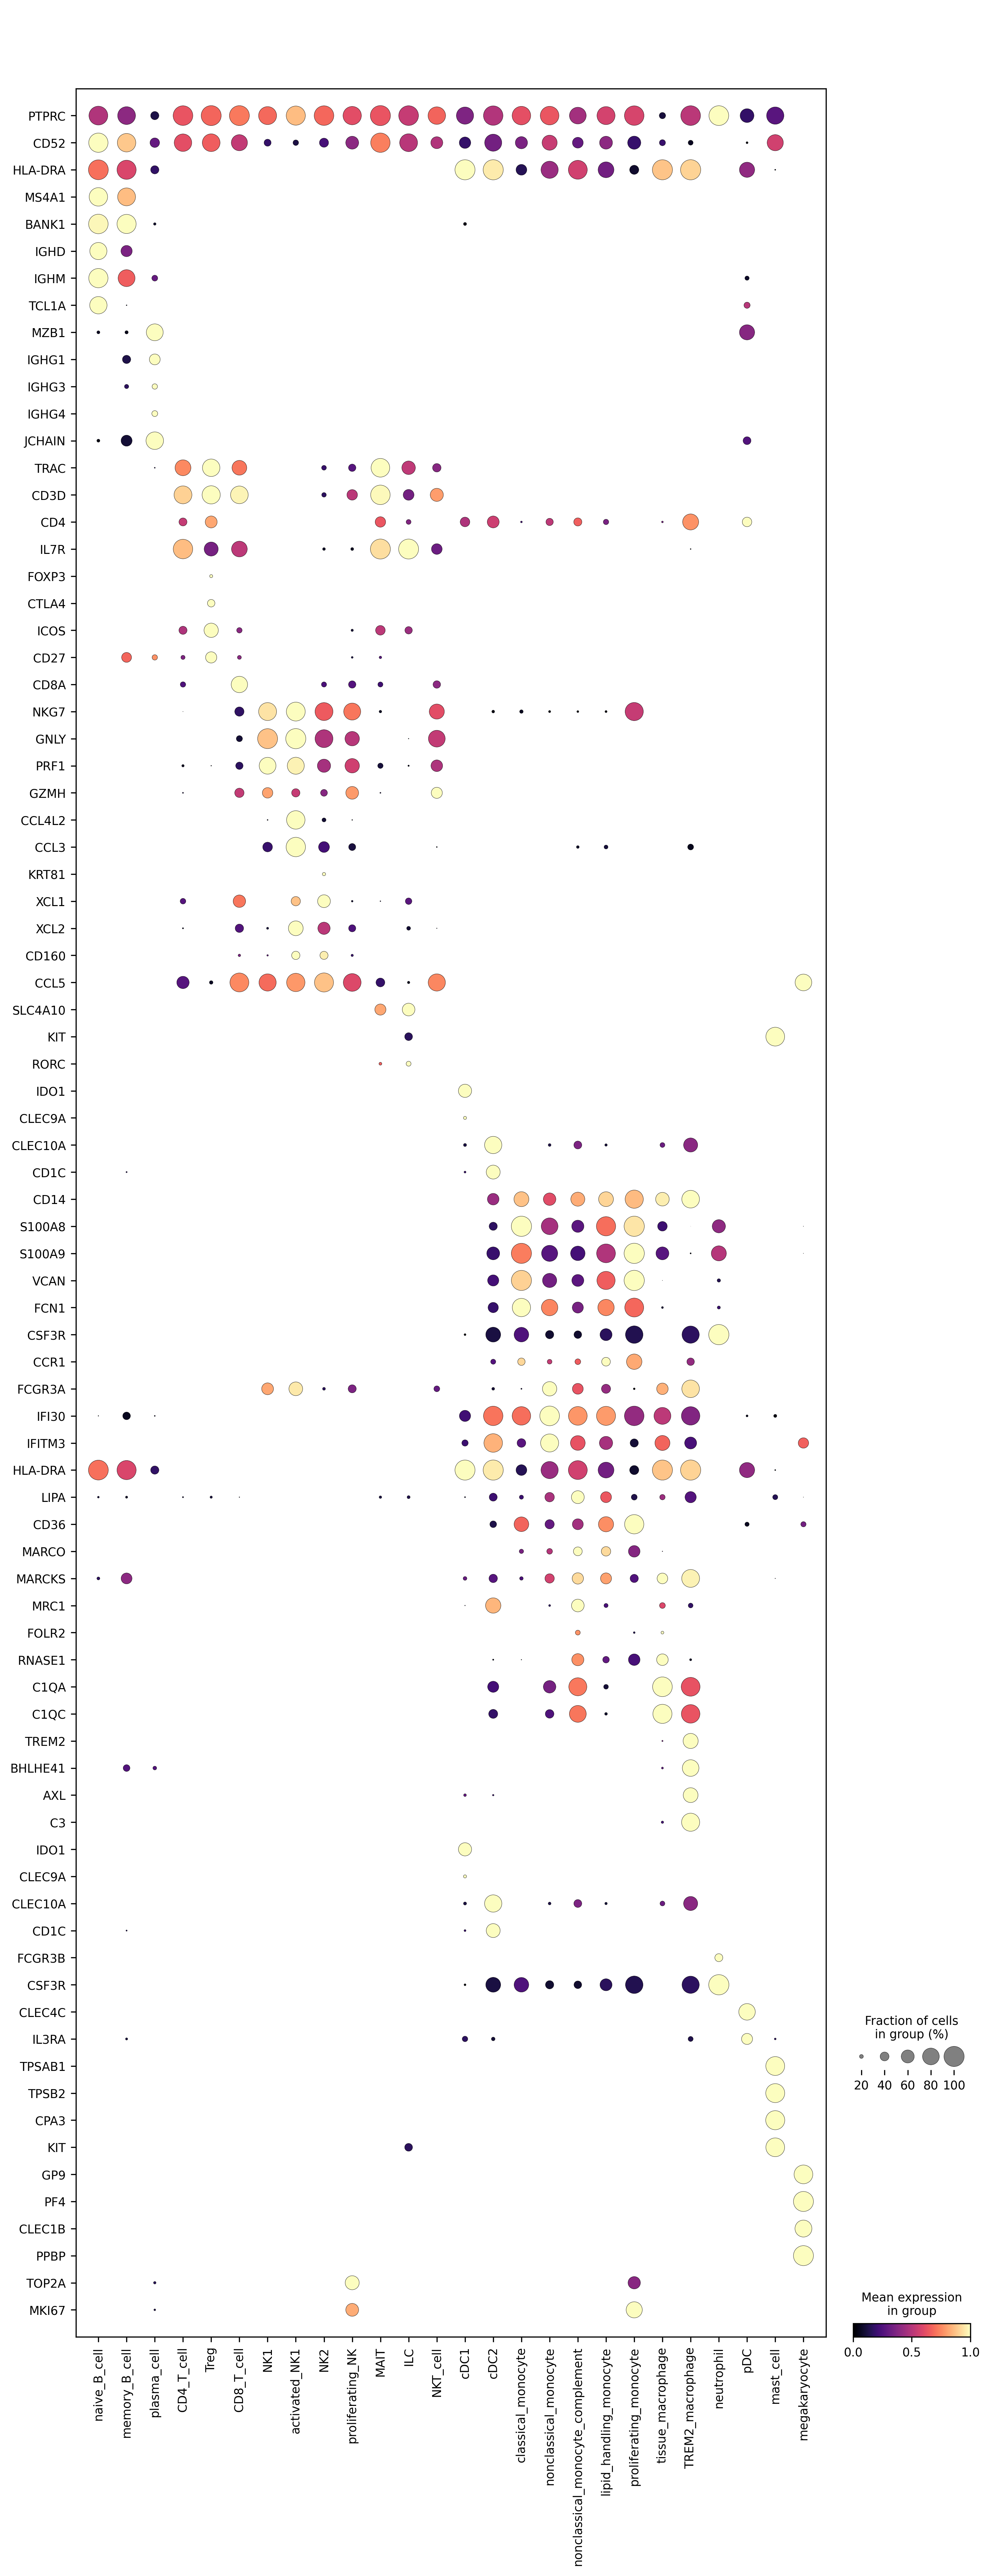

In [16]:
supervised_markers = ['PTPRC', 'CD52', 'HLA-DRA', 
                      'MS4A1', 
                      'BANK1', 'IGHD', 'IGHM', 'TCL1A', 
                      'MZB1','IGHG1', 'IGHG3', 'IGHG4', 'JCHAIN',
                      
                      'TRAC', 'CD3D', 'CD4', 'IL7R',
                      'FOXP3', 'CTLA4', 'ICOS', 'CD27', 'CD8A', 
                      'NKG7', 'GNLY', 'PRF1', 'GZMH',
                        'CCL4L2', 'CCL3', 'KRT81', 'XCL1', 'XCL2', 'CD160', 
                      'CCL5',
                      'SLC4A10','KIT', 'RORC',
                      'IDO1', 'CLEC9A', 'CLEC10A', 'CD1C',                      
                    'CD14', 'S100A8', 'S100A9', 'VCAN', 'FCN1', 'CSF3R', 'CCR1',
                     'FCGR3A', 'IFI30', 'IFITM3', 'HLA-DRA', 'LIPA', 'CD36', 'MARCO', 'MARCKS',
                      'MRC1', 'FOLR2', 'RNASE1', 'C1QA', 'C1QC',
                     'TREM2', 'BHLHE41', 'AXL', 'C3', 'IDO1', 'CLEC9A', 'CLEC10A', 'CD1C',
                     'FCGR3B', 'CSF3R',
                      'CLEC4C', 'IL3RA',
                      'TPSAB1', 'TPSB2', 'CPA3', 'KIT',
                      'GP9', 'PF4', 'CLEC1B', 'PPBP',
                      'TOP2A', 'MKI67']
sc.pl.dotplot(immune_adata, groupby = 'cell_type', 
              var_names = supervised_markers,
              dendrogram = False,swap_axes =True, cmap = 'magma', 
              standard_scale='var', dot_max = 1, dot_min = 0.1,
             #save = 'supervised_immune_markers.pdf'
             )

In [9]:
#read markers
immune_markers = pd.read_csv("./data/markers/immune_markers.csv", index_col = 0)
cells = pd.unique(immune_markers.cell_type)
mrk = []
for mk in list(cells):
    mk = immune_markers[immune_markers.cell_type.isin([mk])].head(5)
    mk['Symbol'] = mk.gene
    mrk.append(np.array(mk['gene']))
genes_plot = np.concatenate(mrk).ravel()
cluster_cats = list(immune_adata.obs['cell_type'].cat.categories)
genes_plot_dict = dict(zip(cluster_cats, mrk))

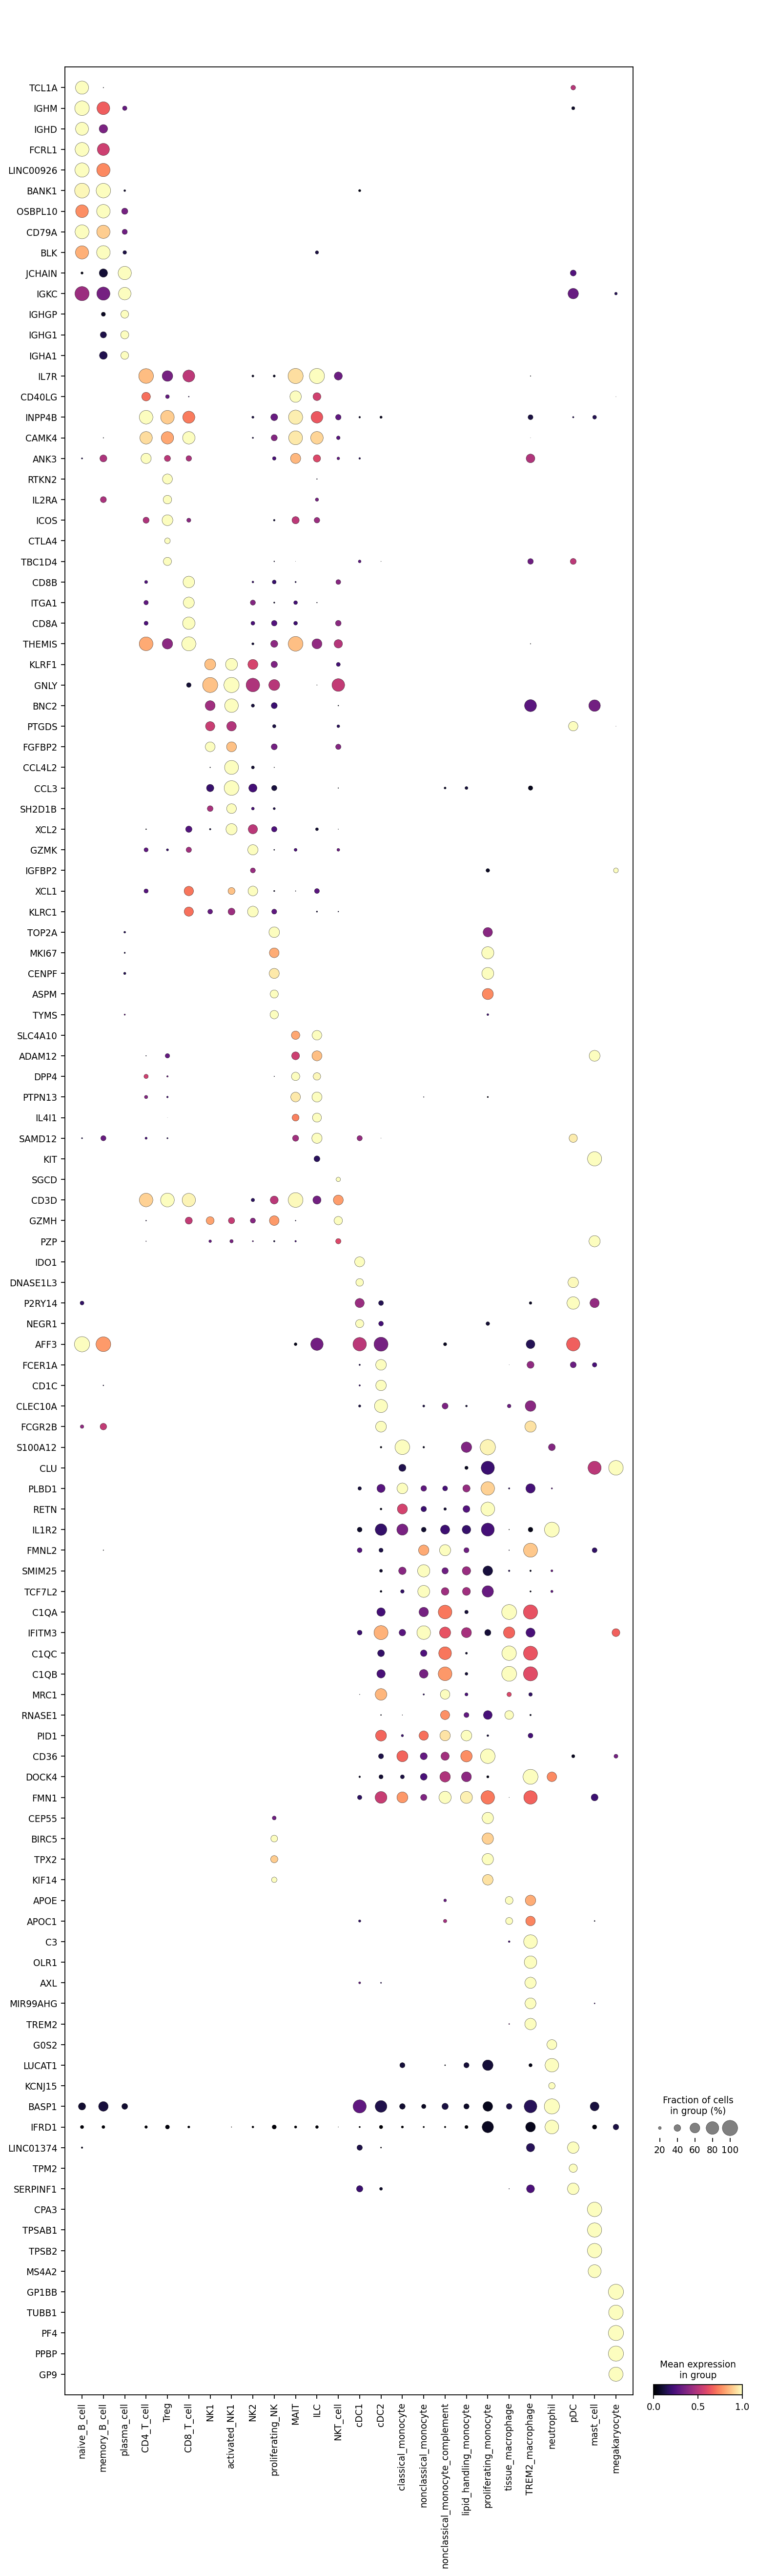

In [9]:
gp, ind = np.unique(genes_plot, return_index=True)
gp = gp[np.argsort(ind)]
sc.set_figure_params(figsize=(10,15), fontsize=10)
sc.pl.dotplot(immune_adata, groupby = 'cell_type', var_names = gp,
              dendrogram = False,swap_axes =True, cmap = 'magma', standard_scale='var', dot_max = 1, dot_min = 0.1, 
             save = 'immune_markers.pdf')

In [ ]:
sc.set_figure_params(figsize=(10,15), fontsize=10)
sc.pl.dotplot(immune_adata, groupby = 'cell_type', var_names = gp,
              dendrogram = False,swap_axes =True, cmap = 'magma', standard_scale='var', dot_max = 1, dot_min = 0.1, 
             save = 'immune_markers.pdf')

In [ ]:
sc_adata = sc.read_h5ad("./data/annotated/scRNAseq_glom_TI_kidney.h5ad")

In [ ]:
#read markers
sc_markers = pd.read_csv("./data/markers/sc_atlas_markers.csv", index_col = 0)
cells = pd.unique(sc_markers.cell_type)
mrk = []
for mk in list(cells):
    mk = sc_markers[sc_markers.cell_type.isin([mk])].head(5)
    mk['Symbol'] = mk.index
    mrk.append(np.array(mk['gene']))
genes_plot = np.concatenate(mrk).ravel()
cluster_cats = list(sc_adata.obs['cell_type'].cat.categories)
genes_plot_dict = dict(zip(cluster_cats, mrk))

In [ ]:
gp, ind = np.unique(genes_plot, return_index=True)
gp = gp[np.argsort(ind)]
sc.set_figure_params(figsize=(10,15), fontsize=10)
sc.pl.dotplot(sc_adata, groupby = 'cell_type', var_names = gp,
              dendrogram = False,swap_axes =True, cmap = 'magma', standard_scale='var', dot_max = 1, dot_min = 0.1, 
             save = 'sc_markers.pdf')

In [4]:
mo_adata = sc.read_h5ad('./data/annotated/multiome_adata.h5ad')

In [5]:
#read markers
mo_markers = pd.read_csv("./data/markers/mo_atlas_markers.csv", index_col = 0)
cells = pd.unique(mo_markers.cell_type)
mrk = []
for mk in list(cells):
    mk = mo_markers[mo_markers.cell_type.isin([mk])].head(5)
    mk['Symbol'] = mk.gene
    mrk.append(np.array(mk['Symbol']))
genes_plot = np.concatenate(mrk).ravel()
cluster_cats = list(mo_adata.obs['cell_type'].cat.categories)
genes_plot_dict = dict(zip(cluster_cats, mrk))

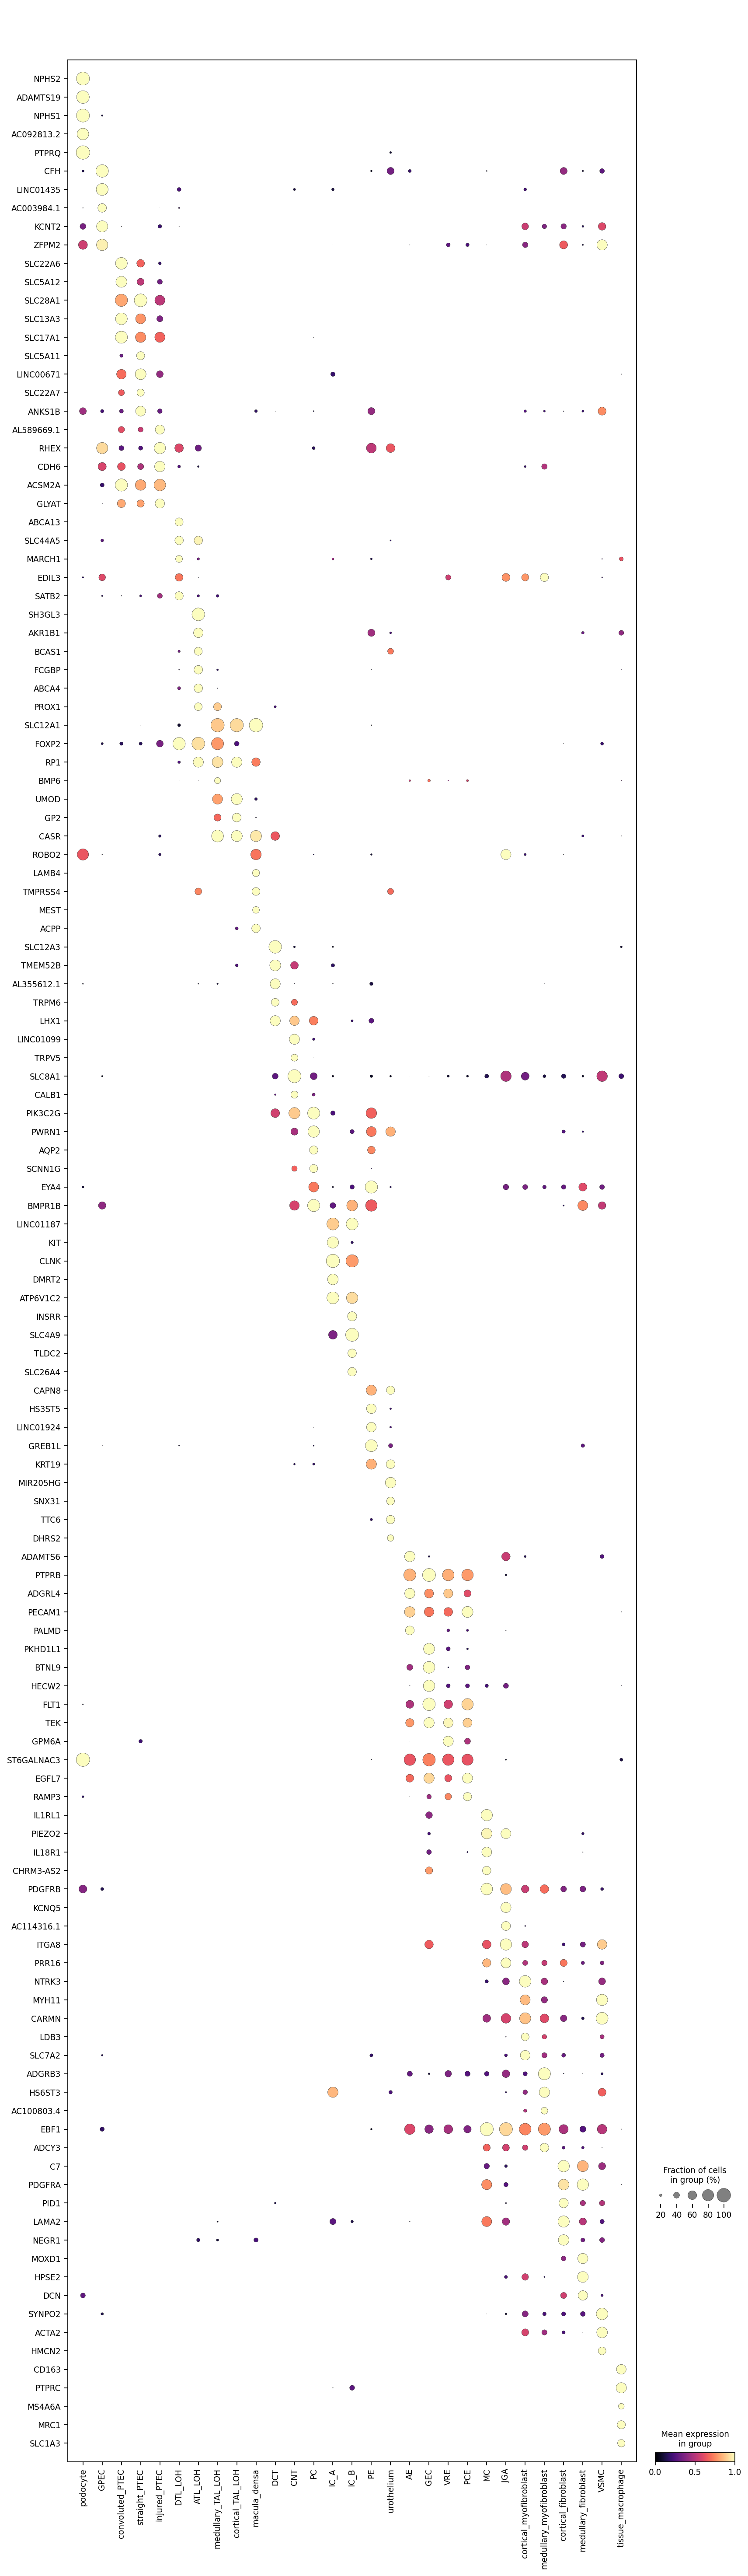

In [6]:
gp, ind = np.unique(genes_plot, return_index=True)
gp = gp[np.argsort(ind)]
sc.set_figure_params(figsize=(10,15), fontsize=10)
sc.pl.dotplot(mo_adata, groupby = 'cell_type', var_names = gp,
              dendrogram = False,swap_axes =True, cmap = 'magma', standard_scale='var', dot_max = 1, dot_min = 0.1, 
             save = 'multiome_markers.pdf')

In [65]:
#perfusion data
perf_adata = sc.read_h5ad('./data/annotated/scRNAseq_perturbation_kidney.h5ad')

In [66]:
#read markers
perfusion_markers = pd.read_csv("./data/markers/perfusion_markers.csv", index_col = 0)
cells = pd.unique(perfusion_markers.cell_type)
mrk = []
for mk in list(cells):
    mk = perfusion_markers[perfusion_markers.cell_type.isin([mk])].head(5)
    mk['Symbol'] = mk.gene
    mrk.append(np.array(mk['Symbol']))
genes_plot = np.concatenate(mrk).ravel()
cluster_cats = list(perf_adata.obs['cell_type'].cat.categories)
genes_plot_dict = dict(zip(cluster_cats, mrk))

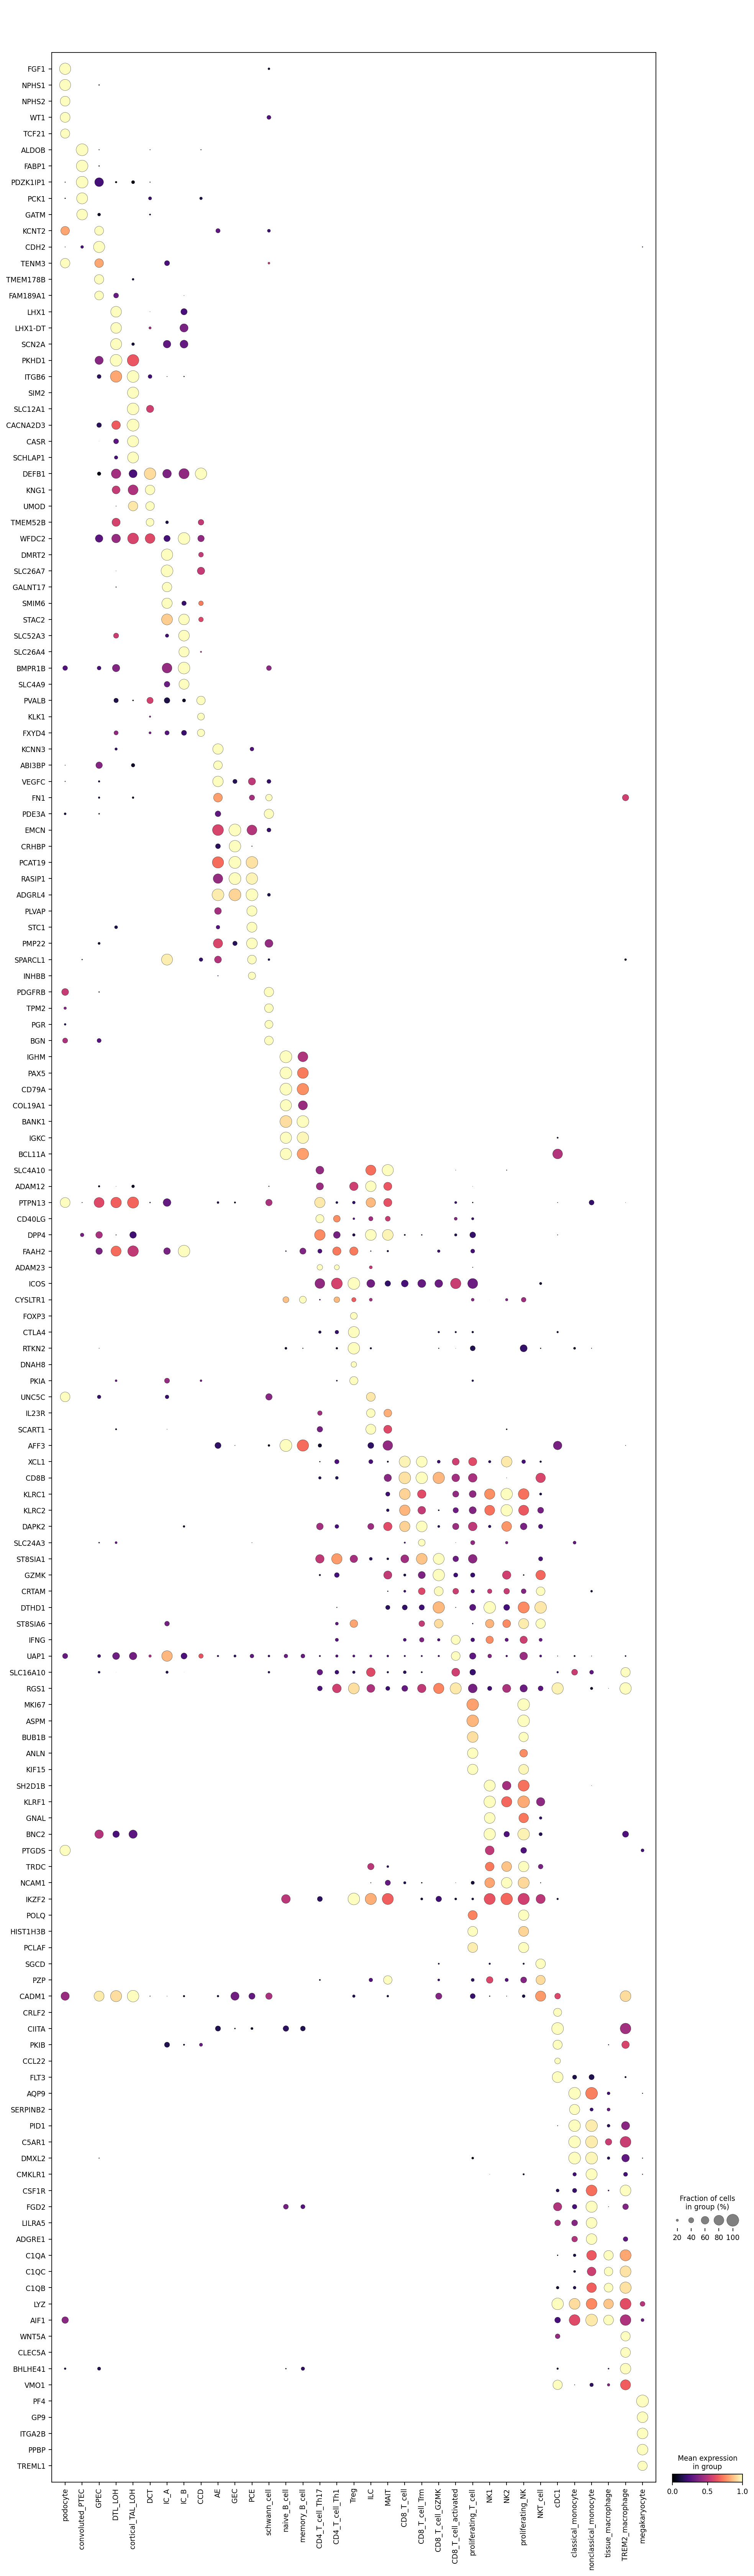

In [67]:
gp, ind = np.unique(genes_plot, return_index=True)
gp = gp[np.argsort(ind)]
sc.set_figure_params(figsize=(10,15), fontsize=10)
sc.pl.dotplot(perf_adata, groupby = 'cell_type', var_names = gp,
              dendrogram = False,swap_axes =True, cmap = 'magma', standard_scale='var', dot_max = 1, dot_min = 0.1, 
             save = 'perfusion_markers.pdf')

In [16]:
#sortseq markers
sortseq_adata = sc.read_h5ad('./data/annotated/perfusion_sortseq.h5ad')

In [38]:
#read markers
sortseq_markers = pd.read_csv("./data/markers/sortseq_markers.csv", index_col = 0)
cells = pd.unique(sortseq_markers.cell_type)
mrk = []
for mk in list(cells):
    mk = sortseq_markers[sortseq_markers.cell_type.isin([mk])].head(7)
    mk['Symbol'] = mk.gene
    mrk.append(np.array(mk['Symbol']))
genes_plot = np.concatenate(mrk).ravel()
cluster_cats = list(sortseq_adata.obs['cell_type'].cat.categories)
genes_plot_dict = dict(zip(cluster_cats, mrk))

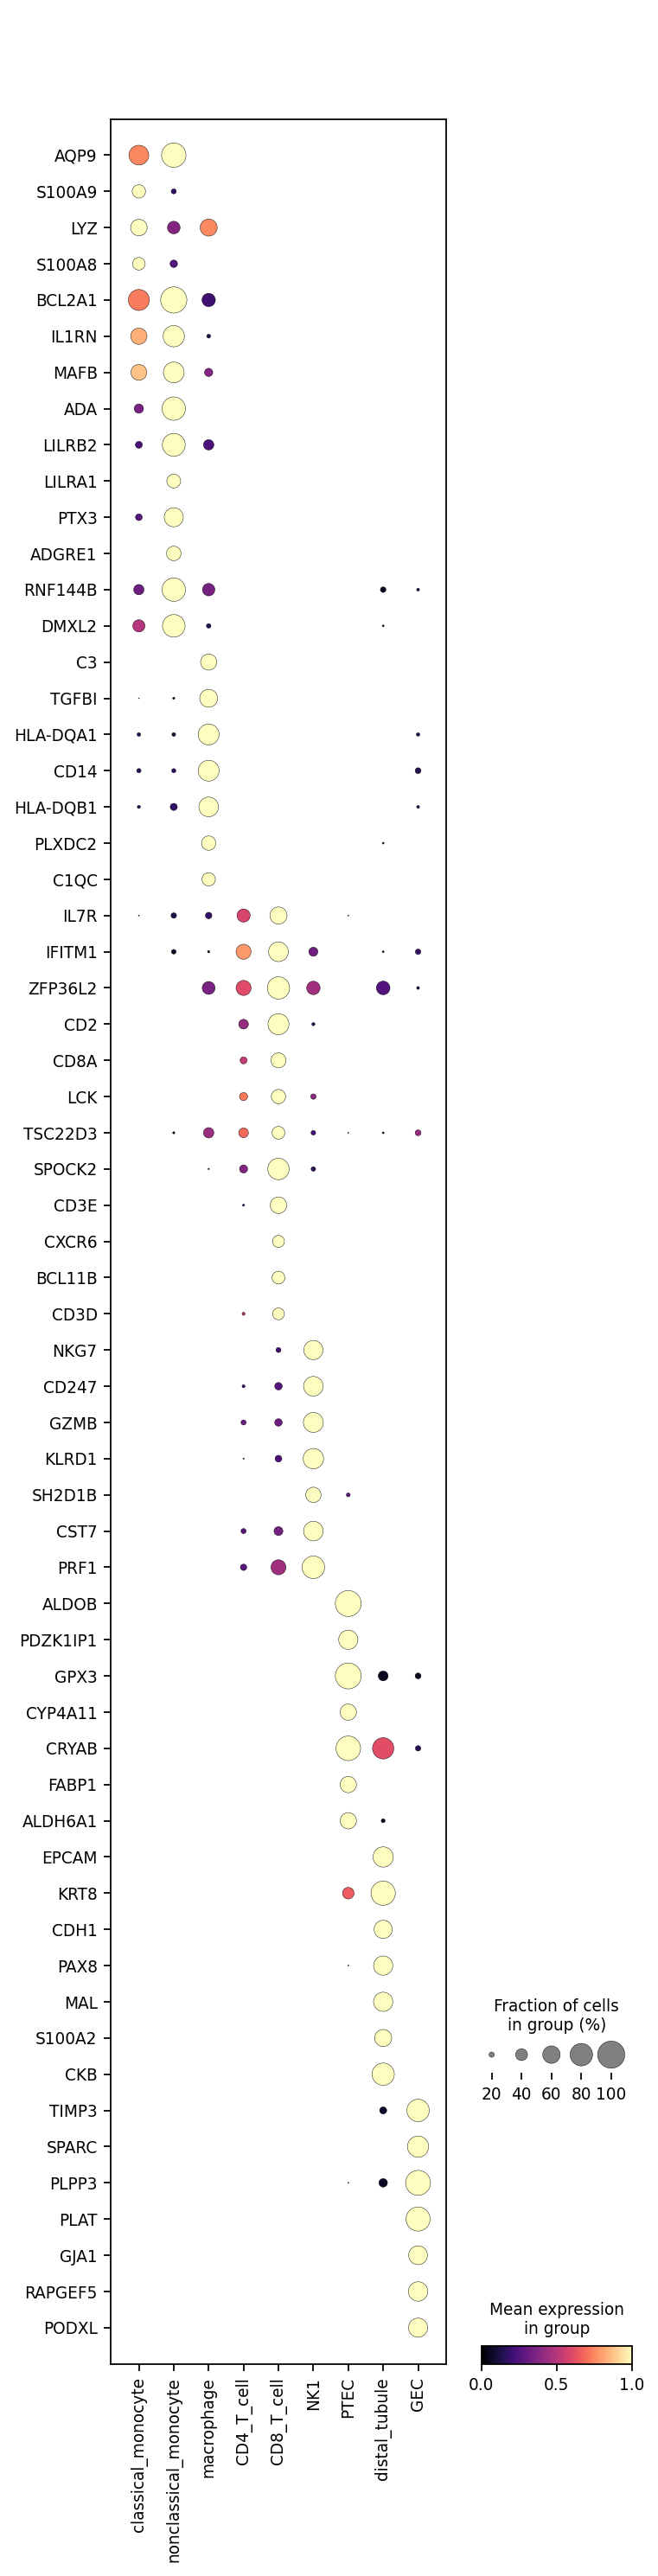

In [40]:
gp, ind = np.unique(genes_plot, return_index=True)
gp = gp[np.argsort(ind)]
sc.set_figure_params(figsize=(10,15), fontsize=10)
sc.pl.dotplot(sortseq_adata, groupby = 'cell_type', var_names = gp,
              dendrogram = False,swap_axes =True, cmap = 'magma', standard_scale='var', dot_max = 1, dot_min = 0.1,
             save = 'sortseq_markers.pdf')

In [61]:
#plot the markers that we describe in figure 2
f2_markers = ['CCL3', 'CSF3', 'CXCL1', 'CXCL2', 'CXCL3','CXCL8',
'IL1A', 'IL1B', 'IL6', 'TNF', 'XCL1', 'XCL2']

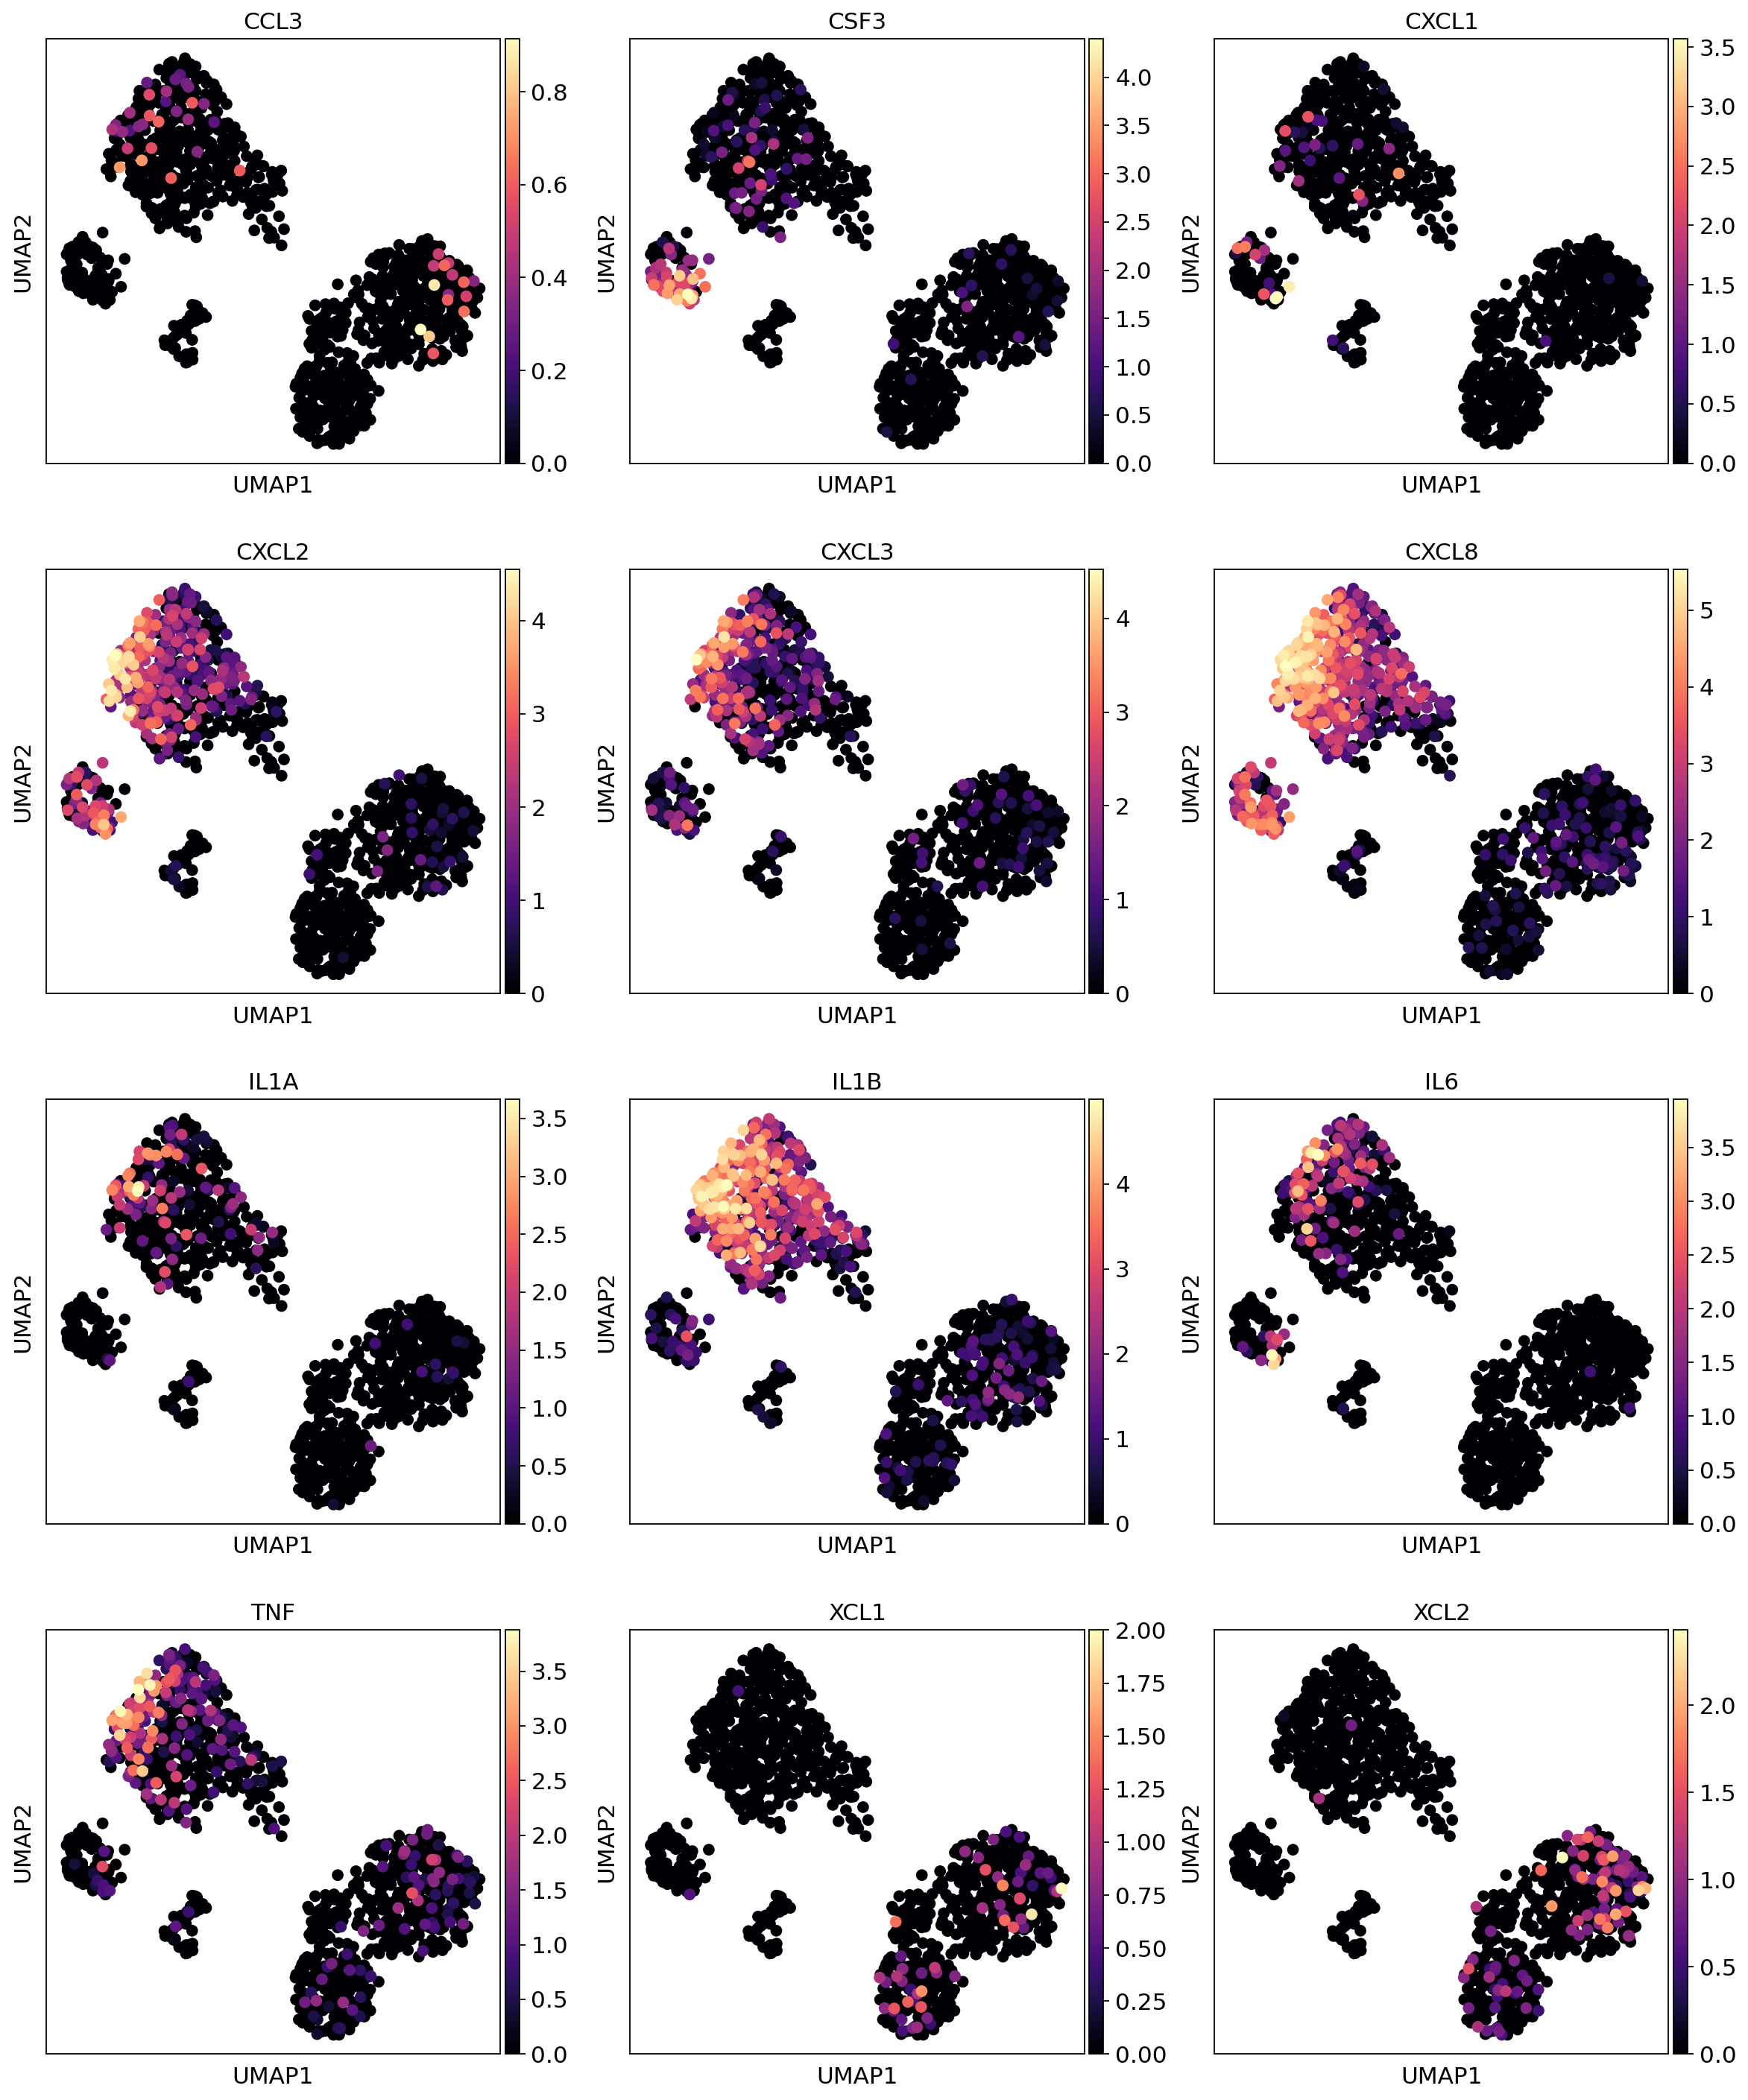

In [64]:
sc.pl.umap(sortseq_adata, color =f2_markers, size =200, cmap = 'magma', ncols = 3, save = 'sortseq_umap_response.pdf')